# Analysis of sales funnel data and A/A/B test results

# Description of the project

As part of the project, it is planned to analyze the data of the online store for individual events for a certain period of time.

Project goals:
- analyze the sales funnel. Find out how users reach the purchase and how many users get stuck at each stage
- analyze the results of the A/A/B test. Let's test the hypothesis that changing fonts does not affect the store's sales funnel.

# Description of data

During the project, we will analyze data from the application log.
Each entry in the log is a user action, or event.
- EventName — event name;
- DeviceIDHash — unique user identifier;
- EventTimestamp — event time;
- ExpId is the number of the experiment: 246 and 247 are the control groups, and 248 is the experimental group

## Data preprocessing

In [1]:
#import libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import numpy as np
import math as mth
from datetime import datetime
from plotly import graph_objects as go
from scipy import stats as st

In [2]:
#load dataset
data = pd.read_csv('./datasets/logs_exp.csv', sep='\t')

In [3]:
#check dataset
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#check data for missing values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


There are no gaps in the data. Additionally, it is necessary to check the data for complete duplicates, as well as change the data type (and convert the data to a meaningful date) in the timestamp column.

In [5]:
#checking for full duplicates
print(data.duplicated().sum())

413


In [6]:
#remove full duplicates
data = data.drop_duplicates().reset_index(drop=True)

In [7]:
#rename columns
data.columns = ['event_name', 'device_id', 'event_ts', 'group_id']

In [8]:
#adding data columns
data['event_dt'] = data['event_ts'].map(
    lambda x: datetime.fromtimestamp(x)
)

data['event_date'] = data['event_ts'].map(
    lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d')
)

In [9]:
#check dataset transformations
data.head()

,event_name,device_id,event_ts,group_id,event_dt,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 07:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 14:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 14:48:42,2019-07-25


**Conclusions:**

As part of the data preprocessing, we prepared the data for further verification and analysis:

- checked the data for gaps and they were not found
- checked the data for complete duplicates and deleted 413 such lines
- replaced the column names with convenient ones
- added a column with date and time data
- added a separate column with the date for further analysis by day

## Preliminary data analysis

After preprocessing the data, we will conduct a preliminary analysis and check the data.

In [10]:
#посчитаем сколько всего событий в логе сейчас в данных
print('Number of events in dataset:', len(data['event_name']))

#посчитаем количество уникальных событий в логе сейчас в данных
print('Number of unique events:', data['event_name'].nunique())

#посчитаем сколько всего пользователей в логе сейчас в данных
print('Number of users:', data['device_id'].nunique())

event_cnt = data.groupby('device_id').agg({'event_name': 'count'})
print('Average events per user:', "{0:.2f}".format(event_cnt['event_name'].mean()))

Number of events in dataset: 243713
Number of unique events: 5
Number of users: 7551
Average events per user: 32.28


In [11]:
#рассчитаем максимальную и минимальную даты в данных
print('Min date:', data['event_dt'].min())
print('Max date:', data['event_dt'].max())

Min date: 2019-07-25 07:43:36
Max date: 2019-08-08 00:15:17


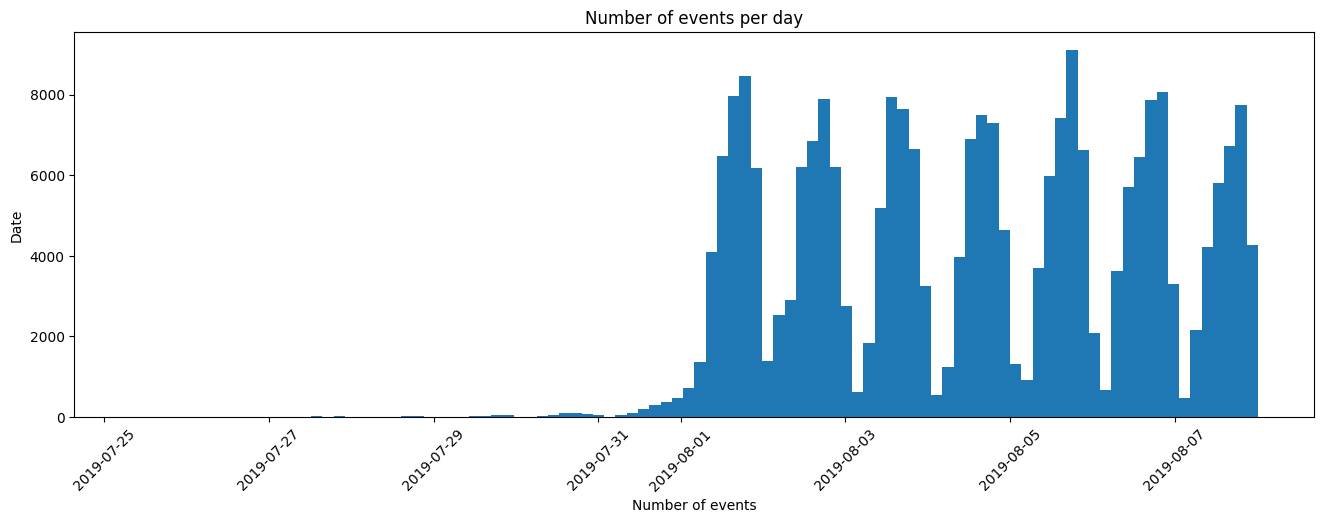

In [12]:
#draw a plot to show number of events per date
plt.figure(figsize=(16,5))
plt.hist(data['event_dt'], bins=100)
plt.title('Number of events per day')
plt.xlabel("Number of events")
plt.ylabel("Date")
plt.xticks(rotation=45)
plt.show()

The graph shows how from August 1 and onward, every day we have a sharp increase in the number of events during the day and decrease by the end of the day. The picture for the second week for each day is very similar. There is practically no data for the first week compared to the second.

In [13]:
#build a table by the number of events and the number of unique users by date
print(data.groupby('event_date').agg({'event_name': 'count', 'device_id': 'nunique'}))

            event_name  device_id
event_date                       
2019-07-25           9          7
2019-07-26          30         21
2019-07-27          55         39
2019-07-28         104         68
2019-07-29         181        132
2019-07-30         397        283
2019-07-31        1213        798
2019-08-01       35767       3688
2019-08-02       35571       3641
2019-08-03       33602       3472
2019-08-04       32583       3511
2019-08-05       36075       3803
2019-08-06       36270       3933
2019-08-07       31788       3682
2019-08-08          68         23


It is obvious that the data in the logs is not equally complete for two weeks. In the first week, there is much less data and data on events and users can distort the analysis. Therefore, for further analysis, it would be correct to discard older data and leave only all events since August 1st.
In total, we will have data for one week instead of two.

In [14]:
#collect data without old dates into a new dataframe
df = data.query('event_date >= "2019-08-01"')

In [15]:
#count how many events and users we lost by discarding the old data
print('Number of deleted events in data:', len(data['event_name']) - len(df['event_name']))
print('Number of unique users removed:', data['device_id'].nunique() - df['device_id'].nunique())

print('Share of deleted events:', "{0:.2f}".format((1 - (len(df['event_name']) / len(data['event_name'])))*100),'%')
print('Percentage of deleted users:', "{0:.2f}".format((1 - (df['device_id'].nunique() / data['device_id'].nunique()))*100),'%')

Number of deleted events in data: 1989
Number of unique users removed: 13
Share of deleted events: 0.82 %
Percentage of deleted users: 0.17 %


In [16]:
#check that the data contains users from all three experimental groups
print(df.groupby('group_id').agg({'event_name': 'count', 'device_id': 'nunique'}))

          event_name  device_id
group_id                       
246            79556       2484
247            77293       2517
248            84875       2537


Preliminarily, there are events and unique users in the data in all three groups of the A / A / B test, and at first glance they are distributed more or less evenly.

In [17]:
#check that each user belongs to only one group (no users with number of groups > 1)

double_group = df.groupby('device_id').agg({'group_id': 'nunique'}).query('group_id > 1').count()
double_group

group_id    0
dtype: int64

**Conclusions:**

1. In the original dataset there was incomplete data for the first week, which we removed so that they do not distort the results, both in the analysis of the funnel and in the analysis of the results of the A / A / B test. By discarding this data, we lost only 1.2% of events and 0.2% of users.
2. At first glance, there are events and unique users in the data in all three groups of the A/A/B test, and they are distributed relatively evenly.

## Event funnel analysis

After a preliminary analysis, we will analyze the sales funnel in more detail. To do this, let's see what events are in the log, how often they occur.

In [18]:
print(df.groupby('event_name').agg({'device_id': 'count'}).sort_values(by='device_id', ascending=False))

                         device_id
event_name                        
MainScreenAppear            117889
OffersScreenAppear           46531
CartScreenAppear             42343
PaymentScreenSuccessful      33951
Tutorial                      1010


Assume based on the names and frequency that:
- MainScreenAppear - the appearance of the main screen of the store (most likely, all users should have such an event)
- OffersScreenAppear - the appearance of a screen with an offer (probably a separate page with promotions and offers)
- CartScreenAppear - transition to the screen with a basket
- PaymentScreenSuccessful - screen with information about successful payment for goods
- Tutorial - tutorial page

Let's calculate how many users made each of these events and the proportion of users who made the event at least once.

In [19]:
users_cnt = df.groupby('event_name').agg({'device_id': 'nunique'})
users_cnt['users_%'] = users_cnt['device_id'] / df['device_id'].nunique() * 100
users_cnt['users_%'] = users_cnt['users_%'].round(2)
users_cnt = users_cnt.reset_index()
print(users_cnt.sort_values(by='device_id', ascending=False))

                event_name  device_id  users_%
1         MainScreenAppear       7423    98.47
2       OffersScreenAppear       4597    60.98
0         CartScreenAppear       3736    49.56
3  PaymentScreenSuccessful       3540    46.96
4                 Tutorial        843    11.18


As expected, the main screen is shown to almost all users. Interestingly, almost half of users reach the cart and ~47% of users make purchases. Only 11% of users go to the learning screen.

Let's assume that the transition of users through the sales funnel occurs like this:

- Step 1. The appearance of the main screen (where the user selects a product and adds it to the cart)
- Step 2. Go to the screen with the product (OffersScreenAppear)
- Step 3. Adding an item to the cart
- Step 4. Screen with successful payment (in case of payment).

The step with the transition to the screen with Tutorial will not be taken into account for the analysis of the funnel, because it is not consistent in such a funnel.

As part of the analysis of the funnel of events, we will calculate what proportion of users go to the next step of the funnel (from the number of users on the previous one).

In [20]:
#rebuild the dataset without the Tutorial step
users_cnt = users_cnt.query('event_name != "Tutorial"')
users_cnt = users_cnt.sort_values(by='device_id', ascending=False)

#add a column with the number of users in the previous step
users_cnt['prv_step_users'] = users_cnt["device_id"].shift()
users_cnt = users_cnt.reset_index(drop=True)

#calculate conversion per step
users_cnt['%_prv_step_users'] = users_cnt['device_id'] / users_cnt['prv_step_users'] * 100
users_cnt['%_prv_step_users'] = users_cnt['%_prv_step_users'].round(2)

users_cnt

,event_name,device_id,users_%,prv_step_users,%_prv_step_users
0,MainScreenAppear,7423,98.47,NaN,NaN
1,OffersScreenAppear,4597,60.98,7423.0,61.93
2,CartScreenAppear,3736,49.56,4597.0,81.27
3,PaymentScreenSuccessful,3540,46.96,3736.0,94.75


In [21]:
#draw a funnel

fig = go.Figure(go.Funnel(
    y = users_cnt['event_name'],
    x = users_cnt['device_id'],
    textposition = "inside",
    textinfo = "value+percent initial")
    )

fig.show()

**Output:**

More users are lost in the second step. About 38% of users do not go to the screen with the description of the product offer.
It is also worth noting that more than 81% of users who go to the product description end up adding it to the cart.
Surprisingly, 94.8% of users who go to the cart end up paying for the purchase within less than a week.

As a result, 47.7% of users from those who were able to get to the main screen of the application reach the stage of purchasing a product.

## Analysis of the results of the experiment

Let's analyze the results of A/A/B testing.

To do this, we will use a hypothesis test about the equality of user shares (z-test) in groups at each stage of the event funnel.

If the proportions in the groups are perfectly equal, the difference between them will be zero. For each pair of groups and each event, we calculate how statistically significant the current difference in proportions is.

Thus, **we will formulate a null hypothesis** - the proportions in the groups (the proportion of users who have reached each stage from the initial number of users in the group) are equal.

**Alternative hypothesis** - changing fonts in the experimental group changes the proportions (shares) of users who reach a certain stage of the funnel of events (in one direction or another).

In [22]:
#count the number of unique users by groups
users_by_groups = df.groupby('group_id').agg({'device_id': 'nunique'})
users_by_groups = users_by_groups.reset_index()
users_by_groups

,group_id,device_id
0,246,2484
1,247,2517
2,248,2537


In [23]:
#collect data by groups, number of events, unique users into a separate dataframe
#and the percentage of users from the group who performed the action
group_cnt = df.groupby(['group_id', 'event_name']).agg({'event_ts': 'count', 'device_id': 'nunique'})
group_cnt = group_cnt.reset_index()
group_cnt.head()

,group_id,event_name,event_ts,device_id
0,246,CartScreenAppear,14697,1266
1,246,MainScreenAppear,37855,2450
2,246,OffersScreenAppear,14829,1542
3,246,PaymentScreenSuccessful,11858,1200
4,246,Tutorial,317,278


In [24]:
#add the initial number of unique users by groups to the dataframe
group_cnt = group_cnt.merge(users_by_groups, on='group_id', how='left')
group_cnt.columns = ['group_id', 'event_name', 'event_ts', 'device_id', 'users_by_group']

In [25]:
#calculate the shares of users from the initial ones for each step for each group
group_cnt['user_%'] = group_cnt['device_id'] / group_cnt['users_by_group'] * 100
group_cnt['user_%'] = group_cnt['user_%'].round(2)
group_cnt = group_cnt.sort_values(by=['group_id', 'device_id'], ascending=[True, False])
group_cnt

,group_id,event_name,event_ts,device_id,users_by_group,user_%
1,246,MainScreenAppear,37855,2450,2484,98.63
2,246,OffersScreenAppear,14829,1542,2484,62.08
0,246,CartScreenAppear,14697,1266,2484,50.97
3,246,PaymentScreenSuccessful,11858,1200,2484,48.31
4,246,Tutorial,317,278,2484,11.19
6,247,MainScreenAppear,39294,2479,2517,98.49
7,247,OffersScreenAppear,15237,1524,2517,60.55
5,247,CartScreenAppear,12439,1239,2517,49.23
8,247,PaymentScreenSuccessful,9983,1158,2517,46.01
9,247,Tutorial,340,284,2517,11.28


In [26]:
#create a pivot table with shares by groups for visual comparison
group_pivot = group_cnt.pivot_table(index='event_name', columns='group_id', values='user_%')
group_pivot = group_pivot.reset_index()
print(group_pivot.sort_values(by=246, ascending=False))

group_id               event_name    246    247    248
1                MainScreenAppear  98.63  98.49  98.31
2              OffersScreenAppear  62.08  60.55  60.35
0                CartScreenAppear  50.97  49.23  48.52
3         PaymentScreenSuccessful  48.31  46.01  46.59
4                        Tutorial  11.19  11.28  11.08


At first glance, the proportions in the groups look very similar. The key thing is that the funnel for events in each group is similar, which means there are no strong outliers in the data. It remains to check whether the difference in proportions is statistically significant.

In [27]:
#build a function to check groups and events - set as arguments
#name of the event, the first group to check, the second group to check, the dataframe that was assembled for checking
def check_diff(event, group_to_check1, group_to_check2, group_cnt):

    alpha = .01 # critical level of statistical significance

    
    successes = []
    trials = []
    
    group_cnt = group_cnt.reset_index(drop=True)
    group_1 = group_cnt.query('group_id == @group_to_check1 & event_name == @event')
    group_1 = group_1.reset_index(drop=True)

    group_2 = group_cnt.query('group_id == @group_to_check2 & event_name == @event')
    group_2 = group_2.reset_index(drop=True)
    trials.append(group_1['users_by_group'][0])
    trials.append(group_2['users_by_group'][0])
    
    
    

    group_cnt = group_cnt.reset_index(drop=True)
    group_1 = group_cnt.query('group_id == @group_to_check1 & event_name == @event')
    group_1 = group_1.reset_index(drop=True)

    group_2 = group_cnt.query('group_id == @group_to_check2 & event_name == @event')
    group_2 = group_2.reset_index(drop=True)
    successes.append(group_1['device_id'][0])
    successes.append(group_2['device_id'][0])

    # proportion of successes in the first group:
    p1 = successes[0]/trials[0]

    # proportion of successes in the second group:
    p2 = successes[1]/trials[1]

    # proportion of successes in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # difference
    difference = p1 - p2 

    # calculate statistics in standard deviations of the standard normal distribution
       
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # set standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)  


    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Event being checked: ', event)
    print('Groups:', group_to_check1, 'and', group_to_check2)
    print('p-value: ', p_value)

    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the shares')
    else:
        print(
        'Could not reject the null hypothesis, there is no reason to consider the shares different'
        ) 
    print('\n') 
    return ''



We have 2 control groups in the data for the A/A experiment to check the correctness of all mechanisms and calculations. Let's check if the statistical tests find a difference between samples 246 and 247.

In [28]:
#collect all event names in a list
all_events = group_cnt['event_name'].unique()

#cycle check groups A and A for each event for the difference in shares
for events in all_events:
    check_diff(events, 246, 247, group_cnt)

Event being checked:  MainScreenAppear
Groups: 246 and 247
p-value:  0.6756217702005545
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  OffersScreenAppear
Groups: 246 and 247
p-value:  0.26698769175859516
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  CartScreenAppear
Groups: 246 and 247
p-value:  0.2182812140633792
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  PaymentScreenSuccessful
Groups: 246 and 247
p-value:  0.10298394982948822
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  Tutorial
Groups: 246 and 247
p-value:  0.9182790262812368
Could not reject the null hypothesis, there is no reason to consider the shares different




The test results indicate that there is no statistically significant difference between groups A and A. We can say that grouping works correctly.

In turn, we will also check two pairs of groups - control 247 and experimental 248, as well as control 246 and experimental 248.

In [29]:
for events in all_events:
    check_diff(events, 247, 248, group_cnt)

Event being checked:  MainScreenAppear
Groups: 247 and 248
p-value:  0.6001661582453706
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  OffersScreenAppear
Groups: 247 and 248
p-value:  0.8835956656016957
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  CartScreenAppear
Groups: 247 and 248
p-value:  0.6169517476996997
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  PaymentScreenSuccessful
Groups: 247 and 248
p-value:  0.6775413642906454
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  Tutorial
Groups: 247 and 248
p-value:  0.8151967015119994
Could not reject the null hypothesis, there is no reason to consider the shares different




In [30]:
for events in all_events:
    check_diff(events, 246, 248, group_cnt)

Event being checked:  MainScreenAppear
Groups: 246 and 248
p-value:  0.34705881021236484
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  OffersScreenAppear
Groups: 246 and 248
p-value:  0.20836205402738917
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  CartScreenAppear
Groups: 246 and 248
p-value:  0.08328412977507749
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  PaymentScreenSuccessful
Groups: 246 and 248
p-value:  0.22269358994682742
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  Tutorial
Groups: 246 and 248
p-value:  0.8964489622133207
Could not reject the null hypothesis, there is no reason to consider the shares different




In [31]:
#Add the combined group - 249 to the dataset (the sum of the groups 246 and 247)

for events in all_events:
    grp1 = group_cnt.query('group_id == 246 & event_name == @events')['event_ts']
    grp1 = grp1.reset_index(drop=True)
    grp2 = group_cnt.query('group_id == 247 & event_name == @events')['event_ts']
    grp2 = grp2.reset_index(drop=True)

    grp_united_events = (grp1[0] + grp2[0])


    grp1_dev = group_cnt.query('group_id == 246 & event_name == @events')['device_id']
    grp1_dev = grp1_dev.reset_index(drop=True)
    grp2_dev = group_cnt.query('group_id == 247 & event_name == @events')['device_id']
    grp2_dev = grp2_dev.reset_index(drop=True)
    grp_united_dev = (grp1_dev[0] + grp2_dev[0])


    grp1_user = group_cnt.query('group_id == 246 & event_name == @events')['users_by_group']
    grp1_user = grp1_user.reset_index(drop=True)
    grp2_user = group_cnt.query('group_id == 247 & event_name == @events')['users_by_group']
    grp2_user = grp2_user.reset_index(drop=True)
    grp_united_users = (grp1_user[0] + grp2_user[0])

    grp_united_share = (grp_united_dev)/(grp_united_users) * 100
    
    grp_to_add = {'group_id': 249, 'event_name': events, 'event_ts': grp_united_events, 'device_id': grp_united_dev, 'users_by_group': grp_united_users, 'user_%': grp_united_share}      
    group_cnt = group_cnt.append(grp_to_add, ignore_index=True)
       
    
group_cnt.tail(5)

,group_id,event_name,event_ts,device_id,users_by_group,user_%
15,249,MainScreenAppear,77149,4929,5001,98.560288
16,249,OffersScreenAppear,30066,3066,5001,61.307738
17,249,CartScreenAppear,27136,2505,5001,50.089982
18,249,PaymentScreenSuccessful,21841,2358,5001,47.150570
19,249,Tutorial,657,562,5001,11.237752


In [32]:
#test for combined group (A+A) and experimental group B
for events in all_events:
    check_diff(events, 249, 248, group_cnt)

Event being checked:  MainScreenAppear
Groups: 249 and 248
p-value:  0.39298914928006035
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  OffersScreenAppear
Groups: 249 and 248
p-value:  0.418998284007599
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  CartScreenAppear
Groups: 249 and 248
p-value:  0.19819340844527744
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  PaymentScreenSuccessful
Groups: 249 and 248
p-value:  0.6452057673098244
Could not reject the null hypothesis, there is no reason to consider the shares different


Event being checked:  Tutorial
Groups: 249 and 248
p-value:  0.8333049080125807
Could not reject the null hypothesis, there is no reason to consider the shares different




**Conclusions from the experiment:**

After checking the differences between groups A and A, it was possible to establish that the separation works normally - no statistically significant differences were found between groups.


The test results indicate that there is no statistically significant difference between the A/A/B groups. This means that the changed fonts did not affect users and did not change the funnel of events in the experimental group in either direction.


The level of significance was initially taken very high - 0.01. In this case, only every hundredth result can be a false result. We conducted a total of 20 tests, so the significance level is acceptable for this hypothesis testing.

## Conclusions on the results of the project

As part of the project, we analyzed the sales funnel and analyzed the results of the A / A / B test.
In addition, prior to the start of the analysis, the data were pre-processed and the data were checked for completeness.
It turned out that the original dataset had incomplete data that we removed so that they would not distort the results.


**Sales funnel:**
As part of the analysis of the sales funnel, it was assumed that the user first enters the main page through the funnel of events, selects products there and adds them to the cart, goes to the cart and makes a payment.
Based on the analysis of such a funnel of events, several important points can be noted:
1. Not all users get to the main screen (about 2% of users get lost somewhere - needs to be checked).
2. The store has a very high conversion from cart to payment. 94.8% of users who go to the cart end up paying for the purchase within less than a week.
3. About half of users do not go to the basket from the main screen
    
Thus, we can say that those users who are interested in something on the main page and add the product to the cart almost always end up buying it, while every second user is interested in some products.


**Conclusions from the A/A/B test and experiment with fonts:**

1. Grouping works fine - no statistically significant difference was found between control groups A and A. For all events, it was not possible to refute the null hypothesis that the proportions in the groups were not statistically different.

2. Exactly the same result was obtained in all comparisons between groups A and group B and, importantly, for all events and with a high level of significance. It can be concluded that there is no statistically significant difference between groups A/A/B. This means that the changed fonts did not affect the funnel of events in the experimental group either positively or negatively.